In [4]:
import numpy as np
import random
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "models/llama3-8b/"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

import torch
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.__version__

cuda


'2.6.0.dev20241117+cu124'

In [2]:
#"nf4" stands for Non-Finite 4-bit quantization, a specialized quantization scheme
# designed to handle non-finite numbers (e.g., NaN, Infinity)
torch.cuda.empty_cache()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

device_map = {"": 0}  # This will map the entire model to the first GPU

hf_token = "abc"  # add your token here

foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    # device_map='auto',
                    use_cache = True,)
                    #use_auth_token = hf_token)

Loading checkpoint shards: 100%|██████████| 4/4 [00:46<00:00, 11.67s/it]


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
                                        #use_auth_token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

In [9]:
def get_outputs(model, inputs, max_new_tokens=200):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.1,
        early_stopping=False, #Can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

In [10]:
input_sentences = tokenizer("Tell a short history of humanity with happy ending.", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=100)
print(foundational_outputs_sentence)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor([[128000,  41551,    264,   2875,   3925,    315,  22706,    449,   6380,
          13696,     13,    320,     16,    340,    791,   3446,    374,   3309,
            304,    279,   1376,    315,    264,  45586,  24162,     11,    719,
            433,    374,   3196,    389,   1972,   4455,    323,  13363,    627,
            644,    420,   3446,     11,    584,   3371,    922,    459,   1567,
            430,   7077,    311,    603,     11,    719,   1101,    922,    682,
          22706,    627,   2181,    753,    922,   1057,   6439,     11,    902,
            527,   8599,    311,    279,   2324,    315,    682,   1274,    627,
           2028,   3446,    374,    922,   1268,    584,    649,   1304,   1057,
           6439,   2731,    627,   1687,   1390,    311,   1501,    499,   1148,
           8741,    994,    584,   2349,   1057,  19451,   7119,  13520,     11,
           1057,  40190,     11,    323,   1057,   4676,    627,   3923,   8741,
            422,    584,   3

In [11]:
output = tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)

In [12]:
import textwrap
print("Generated Output:\n")
for i, sentence in enumerate(output, 1):
    wrapped_sentence = textwrap.fill(sentence, width=80)
    print(f"Output {i}:\n{wrapped_sentence}\n")

Generated Output:

Output 1:
Tell a short history of humanity with happy ending. (1) The story is told in the
form of a fairy tale, but it is based on real events and facts. In this story,
we tell about an event that happened to us, but also about all humanity. It’s
about our lives, which are connected to the life of all people. This story is
about how we can make our lives better. We want to show you what happens when we
change our attitude towards ourselves, our surroundings, and our environment.
What happens if we stop



In [4]:
print(foundation_model.get_memory_footprint()/1000/1000)
print(foundation_model.hf_device_map)

5591.54816
{'': 0}


In [15]:
prompt = "<|system|>\nYou are a friendly chatbot.</s>\n<|user|>\nTell me a funny joke about Large Language Models.</s>\n<|assistant|>\n"
print(prompt)

<|system|>
You are a friendly chatbot.</s>
<|user|>
Tell me a funny joke about Large Language Models.</s>
<|assistant|>



In [17]:
# Create a pipeline
pipe = transformers.pipeline(model=model_name, tokenizer=tokenizer, task='text-generation').to(device)

# We will use the same prompt as we did originally
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

: 

In [6]:
# size of model
import os
torch.save(foundation_model.state_dict(), "models/temp/temp_delme.pt")
print('size (GB): ', os.path.getsize("models/temp/temp_delme.pt")/1e9)
os.remove("models/temp/temp_delme.pt")

size (GB):  5.70308408


In [7]:
torch.save(foundation_model.state_dict(), "models/quantized-4bit-BitsAndBytes.pt")


In [8]:
foundation_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [8]:
model_name = "models/quantized-4bit-BitsAndBytes.pt"

In [12]:
print("Loading model...")
device="cpu"
# torch.cuda.empty_cache()

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float32
# )
# device_map = {"": "cpu"} 
# model = AutoModelForCausalLM.from_pretrained(
#                                             model_name,
#                                             device_map="auto",
#                                             # device_map = device_map,
#                                             quantization_config=bnb_config,
#                                             max_memory={"cpu":"16GB"}
#                                             )
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(model_name, local_files_only=True)

Loading model...


OSError: It looks like the config file at 'models/quantized-4bit-BitsAndBytes.pt' is not a valid JSON file.

In [1]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view, head_view
utils.logging.set_verbosity_error()

inputs = tokenizer.encode("The cat sat on the mat", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

from bertviz import head_view
model_view(attention, tokens)


c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'tokenizer' is not defined

In [57]:
import time
input_text = "Once upon a time in a distant land, there lived a"

# Set pad_token_id explicitly
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Prepare input with attention mask
inputs = tokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
)

input_ids = inputs["input_ids"].repeat(16,1).to(model.device)

attention_mask = inputs["attention_mask"].repeat(16,1).to(model.device)

## time
start_time = time.time()
# Use the attention_mask during generation
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=50,
    num_return_sequences=5,
    pad_token_id=tokenizer.pad_token_id,
)
end_time = time.time()

# Calculate and display inference time
inference_time = end_time - start_time
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"Inference Time: {inference_time:.4f} seconds")
print("Generated Text:")
print(generated_text)

Inference Time: 1659.5449 seconds
Generated Text:
Once upon a time in a distant land, there lived a king who had a beautiful daughter. She was the apple of his eye and he loved her dearly. He was very proud of her and wanted everyone to know how special she was. So


In [60]:
# print(model)
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params//1000/1000/1000:0.1f}B")
    return total_params
    
count_parameters(model)


+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|            model.embed_tokens.weight            | 525336576  |
|      model.layers.0.self_attn.q_proj.weight     |  16777216  |
|      model.layers.0.self_attn.k_proj.weight     |  4194304   |
|      model.layers.0.self_attn.v_proj.weight     |  4194304   |
|      model.layers.0.self_attn.o_proj.weight     |  16777216  |
|       model.layers.0.mlp.gate_proj.weight       |  58720256  |
|        model.layers.0.mlp.up_proj.weight        |  58720256  |
|       model.layers.0.mlp.down_proj.weight       |  58720256  |
|      model.layers.0.input_layernorm.weight      |    4096    |
|  model.layers.0.post_attention_layernorm.weight |    4096    |
|      model.layers.1.self_attn.q_proj.weight     |  16777216  |
|      model.layers.1.self_attn.k_proj.weight     |  4194304   |
|      model.layers.1.sel

8030261248

In [61]:
from torch.nn.utils import prune
import torch.nn as nn

# Define a function to prune channels
def prune_channels(model, amount=0.5):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')

# Prune 50% of the channels in the model
prune_channels(model, amount=0.5)
# print(model)

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params//1000/1000/1000:0.1f}B")
    return total_params
    
count_parameters(model)



+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|            model.embed_tokens.weight            | 525336576  |
|      model.layers.0.self_attn.q_proj.weight     |  16777216  |
|      model.layers.0.self_attn.k_proj.weight     |  4194304   |
|      model.layers.0.self_attn.v_proj.weight     |  4194304   |
|      model.layers.0.self_attn.o_proj.weight     |  16777216  |
|       model.layers.0.mlp.gate_proj.weight       |  58720256  |
|        model.layers.0.mlp.up_proj.weight        |  58720256  |
|       model.layers.0.mlp.down_proj.weight       |  58720256  |
|      model.layers.0.input_layernorm.weight      |    4096    |
|  model.layers.0.post_attention_layernorm.weight |    4096    |
|      model.layers.1.self_attn.q_proj.weight     |  16777216  |
|      model.layers.1.self_attn.k_proj.weight     |  4194304   |
|      model.layers.1.sel

8030261248

In [62]:
# Define a function to prune channels in attention layers
def prune_attention_layers(model, amount=0.5):
    for name, module in model.named_modules():
        if "self_attn.q_proj" in name or "self_attn.k_proj" in name or "self_attn.v_proj" in name or "self_attn.o_proj" in name:
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
            
prune_attention_layers(model, amount=0.5)
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params//1000/1000/1000:0.1f}B")
    return total_params
    
count_parameters(model)


+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|            model.embed_tokens.weight            | 525336576  |
|      model.layers.0.self_attn.q_proj.weight     |  16777216  |
|      model.layers.0.self_attn.k_proj.weight     |  4194304   |
|      model.layers.0.self_attn.v_proj.weight     |  4194304   |
|      model.layers.0.self_attn.o_proj.weight     |  16777216  |
|       model.layers.0.mlp.gate_proj.weight       |  58720256  |
|        model.layers.0.mlp.up_proj.weight        |  58720256  |
|       model.layers.0.mlp.down_proj.weight       |  58720256  |
|      model.layers.0.input_layernorm.weight      |    4096    |
|  model.layers.0.post_attention_layernorm.weight |    4096    |
|      model.layers.1.self_attn.q_proj.weight     |  16777216  |
|      model.layers.1.self_attn.k_proj.weight     |  4194304   |
|      model.layers.1.sel

8030261248

In [53]:
model_name = "models/llama3-8b/"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 4/4 [01:44<00:00, 26.09s/it]


In [55]:
import time
input_text = "Once upon a time in a distant land, there lived a"

# Set pad_token_id explicitly
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Prepare input with attention mask
inputs = tokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
)

input_ids = inputs["input_ids"].repeat(16,1).to(model.device)

attention_mask = inputs["attention_mask"].repeat(16,1).to(model.device)

## time
start_time = time.time()
# Use the attention_mask during generation
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=50,
    num_return_sequences=5,
    pad_token_id=tokenizer.pad_token_id,
)
end_time = time.time()

# Calculate and display inference time
inference_time = end_time - start_time
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"Inference Time: {inference_time:.4f} seconds")
print("Generated Text:")
print(generated_text)

Inference Time: 1742.0705 seconds
Generated Text:
Once upon a time in a distant land, there lived a king and a queen. They were very much in love with each other. They were blessed with a beautiful baby girl. The king and the queen were very happy to have their daughter.


In [26]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params//1000/1000/1000:0.1f}B")
    return total_params
    
count_parameters(model)


+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|            model.embed_tokens.weight            | 525336576  |
|      model.layers.0.self_attn.q_proj.weight     |  16777216  |
|      model.layers.0.self_attn.k_proj.weight     |  4194304   |
|      model.layers.0.self_attn.v_proj.weight     |  4194304   |
|      model.layers.0.self_attn.o_proj.weight     |  16777216  |
|       model.layers.0.mlp.gate_proj.weight       |  58720256  |
|        model.layers.0.mlp.up_proj.weight        |  58720256  |
|       model.layers.0.mlp.down_proj.weight       |  58720256  |
|      model.layers.0.input_layernorm.weight      |    4096    |
|  model.layers.0.post_attention_layernorm.weight |    4096    |
|      model.layers.1.self_attn.q_proj.weight     |  16777216  |
|      model.layers.1.self_attn.k_proj.weight     |  4194304   |
|      model.layers.1.sel

8030261248

In [2]:
import numpy as np

def simulate_llm_quantization(weights, bits=8):
    """
    Simulate quantization of LLM weights/activations.

    Args:
        weights (np.ndarray): The original floating-point weights or activations.
        bits (int): The number of bits to use for quantization (default is 8).

    Returns:
        np.ndarray: The quantized weights/activations.
    """
    # Determine the min and max of the weights/activations
    min_val = weights.min()
    max_val = weights.max()

    # Calculate the scaling factor based on the range of the values
    scale = (max_val - min_val) / (2**bits - 1)

    # Quantize: Convert floating-point values to integers
    quantized = np.round((weights - min_val) / scale).astype(np.int32)

    # Dequantize: Convert back to floating-point representation
    dequantized = (quantized * scale) + min_val

    return dequantized

# Sample weights/activations
weights = np.array([0.122, -0.343, 0.564, -0.782, 0.9534])

# Simulate 8-bit quantization
quantized_weights = simulate_llm_quantization(weights, bits=4)

# Display results
print("Original Weights: ", weights)
print("Impact of Quant: ", quantized_weights)

Original Weights:  [ 0.122  -0.343   0.564  -0.782   0.9534]
Impact of Quant:  [ 0.14354667 -0.31922667  0.60632    -0.782       0.9534    ]


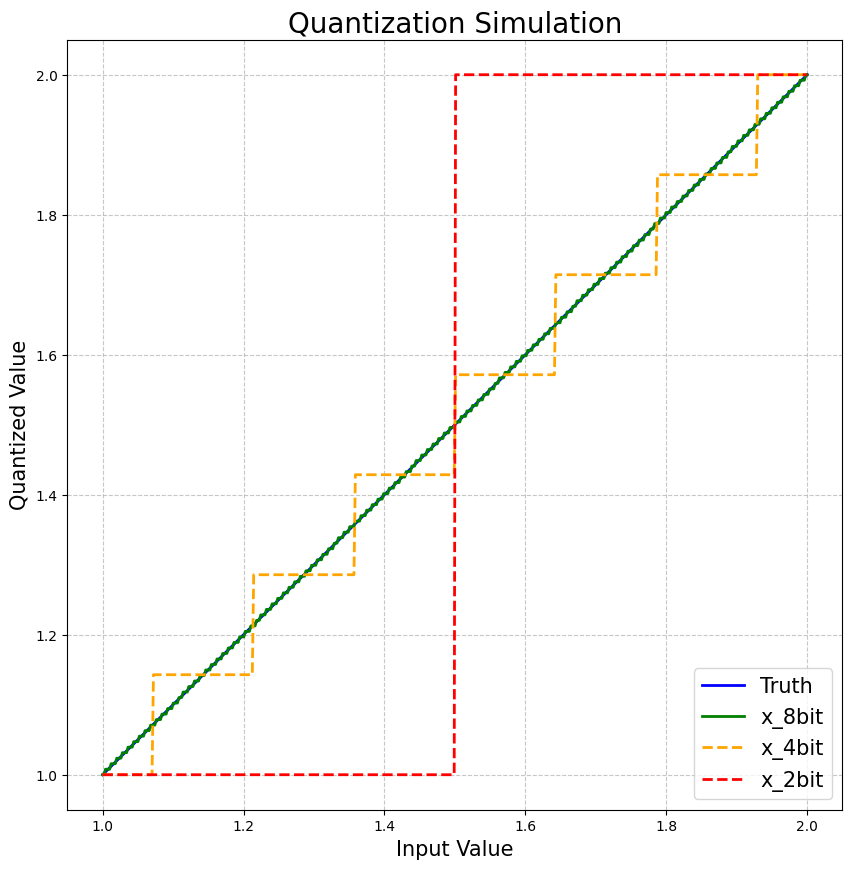

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_quantization(value, bits=4):
    """
    Simulate the quantization of a value given a certain number of bits.

    Args:
        value (float): The input value to be quantized.
        bits (int): The number of bits to use for quantization (default is 4).

    Returns:
        float: The quantized value.
    """
    # Calculate the quantized value by scaling and rounding to the nearest integer
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    # Scale the quantized value back to the original range
    value = quantized_value / (2**(bits - 1) - 1)
    return value

# Generate 100 values linearly spaced between 1 and 4
x = np.linspace(1, 2, 500)

# Simulate quantization using 8-bit precision
x_8bit = np.array([simulate_quantization(val, bits=8) for val in x])

# Simulate quantization using 4-bit precision
x_4bit = np.array([simulate_quantization(val, bits=4) for val in x])

# Simulate quantization using 2-bit precision
x_2bit = np.array([simulate_quantization(val, bits=2) for val in x])

# Create a plot to visualize the original and quantized values
plt.figure(figsize=(10, 10))

# Plot the original values (Truth) with a solid line
plt.plot(x, x, label="Truth", color='blue', linewidth=2)

# Plot the quantized values for 8-bit precision with a solid line
plt.plot(x, x_8bit, label="x_8bit", color='green', linewidth=2)

# Plot the quantized values for 4-bit precision with a dashed line
plt.plot(x, x_4bit, label="x_4bit", color='orange', linestyle='--', linewidth=2)

# Plot the quantized values for 2-bit precision with a dashed line
plt.plot(x, x_2bit, label="x_2bit", color='red', linestyle='--', linewidth=2)

# Add a legend to describe each plot line
plt.legend(fontsize=15, loc='lower right')

# Add a title to the plot
plt.title("Quantization Simulation", fontsize=20)

# Add labels to the axes
plt.xlabel("Input Value", fontsize=15)
plt.ylabel("Quantized Value", fontsize=15)

# Add a grid to the plot for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()
